In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import os
import sys

# ==========================================
# 1. Model Architectures (Reconstructed)
# ==========================================

def get_teacher_resnet101(num_classes=100):
    """
    Reconstructs the Teacher ResNet101 as defined in resnet101.ipynb
    """
    # Initialize standard ResNet101
    # We use pretrained=False because we are about to load your custom weights anyway
    model = torchvision.models.resnet101(pretrained=False)

    # Modifications found in your notebook:
    # 1. Change first conv to accept 32x32 images without destroying info
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    
    # 2. Remove MaxPool to keep spatial dimensions
    model.maxpool = nn.Identity()
    
    # 3. Adjust FC layer for 100 classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

def get_student_mobilenet(num_classes=100, width_mult=1.0):
    """
    Reconstructs the Student MobileNetV2 as defined in student_resnet101_upgraded.ipynb
    Used for both the 'Best' (1.0x) and 'Tiny' (0.5x) models.
    """
    # Initialize MobileNetV2
    model = torchvision.models.mobilenet_v2(num_classes=num_classes, width_mult=width_mult)
    
    # Modifications found in your notebook:
    # 1. CRITICAL FIX: Stride=1 in the first layer for CIFAR-100
    model.features[0][0].stride = (1, 1)
    
    return model

# ==========================================
# 2. Evaluation Utilities
# ==========================================

def load_weights(model, path, device):
    if not os.path.exists(path):
        print(f"[ERROR] Weight file not found: {path}")
        return False
        
    print(f"Loading weights from: {path} ...")
    try:
        checkpoint = torch.load(path, map_location=device)
        
        # Handle different saving methods (state_dict vs full checkpoint)
        if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            state_dict = checkpoint
            
        # Load weights
        model.load_state_dict(state_dict)
        return True
    except Exception as e:
        print(f"[FAIL] Could not load weights: {e}")
        return False

def evaluate(model, dataloader, device, model_name):
    model.eval()
    correct = 0
    total = 0
    start_time = time.time()
    
    # Warmup (optional, helps stabilize timing for first batch)
    with torch.no_grad():
        dummy = torch.randn(1, 3, 32, 32).to(device)
        model(dummy)

    # Actual Inference Loop
    t0 = time.time()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    t1 = time.time()
    inference_time = t1 - t0
    accuracy = 100 * correct / total
    
    return accuracy, inference_time

# ==========================================
# 3. Main Execution
# ==========================================

def main():
    # 1. Setup Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Running on Device: {device}")
    
    # 2. Data Preparation (CIFAR-100 Test Set)
    print("\n[1/3] Preparing Data...")
    # Exact mean/std from your notebook
    stats = ((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*stats),
    ])

    # Downloads dataset if not present
    testset = torchvision.datasets.CIFAR100(root='./data', train=False, 
                                            download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    print(f"Test Set Loaded: {len(testset)} images.")

    # 3. Define Models to Test
    models_config = [
        {
            "name": "Teacher (ResNet101)",
            "path": "savepoints/teacher_resnet101.pth",
            "model_fn": lambda: get_teacher_resnet101(num_classes=100)
        },
        {
            "name": "Student (MobileNetV2 1.0x)",
            "path": "student_mobilenet_cifar_best.pth",
            "model_fn": lambda: get_student_mobilenet(num_classes=100, width_mult=1.0)
        },
        {
            "name": "Tiny Student (MobileNetV2 0.5x)",
            "path": "student_mobilenet_0.5x_best.pth",
            "model_fn": lambda: get_student_mobilenet(num_classes=100, width_mult=0.5)
        }
    ]

    # 4. Run Evaluation
    print("\n[2/3] Starting Evaluation...")
    results = []
    
    for config in models_config:
        print(f"\nTesting {config['name']}...")
        model = config['model_fn']().to(device)
        
        if load_weights(model, config['path'], device):
            acc, duration = evaluate(model, testloader, device, config['name'])
            results.append({
                "name": config['name'],
                "acc": acc,
                "time": duration,
                "fps": len(testset) / duration
            })
            print(f"   -> Accuracy: {acc:.2f}% | Time: {duration:.2f}s")
        else:
            print(f"   -> Skipped (Weights missing)")

    # 5. Final Report
    print("\n[3/3] Final Comparison")
    print("="*75)
    print(f"{'Model Name':<30} | {'Accuracy':<10} | {'Time (s)':<10} | {'FPS':<10}")
    print("-" * 75)
    for res in results:
        print(f"{res['name']:<30} | {res['acc']:<9.2f}% | {res['time']:<9.2f}s | {res['fps']:<9.0f}")
    print("="*75)

if __name__ == "__main__":
    main()

Running on Device: cuda

[1/3] Preparing Data...
Files already downloaded and verified
Test Set Loaded: 10000 images.

[2/3] Starting Evaluation...

Testing Teacher (ResNet101)...
Loading weights from: savepoints/teacher_resnet101.pth ...
   -> Accuracy: 85.43% | Time: 11.92s

Testing Student (MobileNetV2 1.0x)...
Loading weights from: student_mobilenet_cifar_best.pth ...
   -> Accuracy: 69.02% | Time: 0.95s

Testing Tiny Student (MobileNetV2 0.5x)...
Loading weights from: student_mobilenet_0.5x_best.pth ...
   -> Accuracy: 67.86% | Time: 0.56s

[3/3] Final Comparison
Model Name                     | Accuracy   | Time (s)   | FPS       
---------------------------------------------------------------------------
Teacher (ResNet101)            | 85.43    % | 11.92    s | 839      
Student (MobileNetV2 1.0x)     | 69.02    % | 0.95     s | 10491    
Tiny Student (MobileNetV2 0.5x) | 67.86    % | 0.56     s | 17855    


Device: cuda
Loading models...


/home/shree/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shree/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Scanning 'test_images1'...


/home/shree/.local/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Found 11 images. Processing...

Processing complete! Results saved to 'test_images1_results.png'


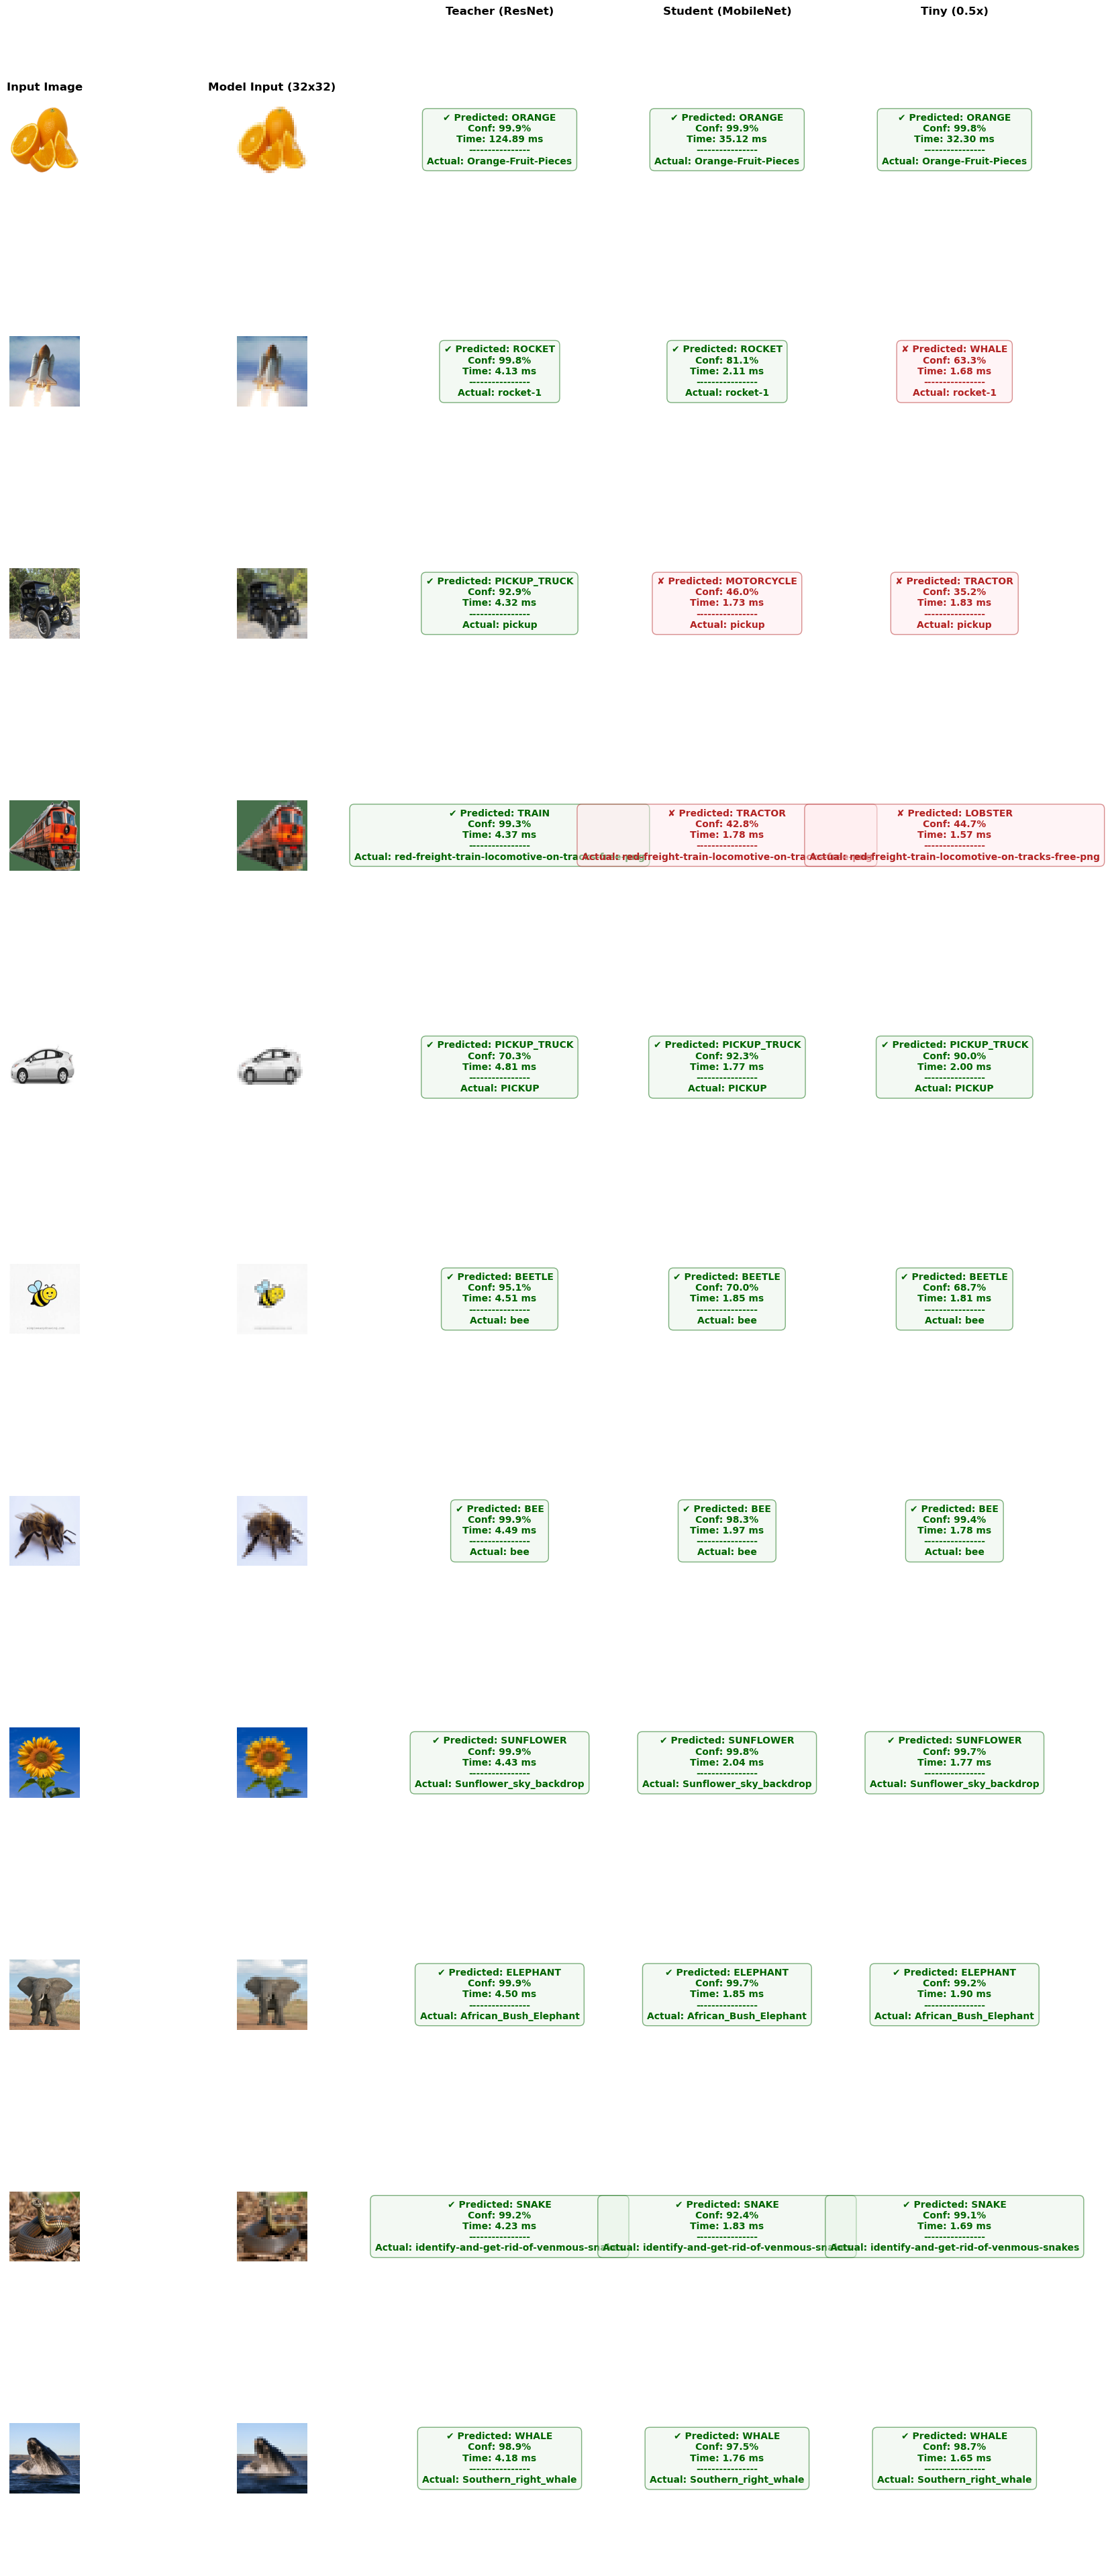

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import time

# ==========================================
# 1. SETUP
# ==========================================
IMAGE_FOLDER = "test_images1"  # Folder name provided by you

# CIFAR-100 Classes
CIFAR100_CLASSES = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 
    'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 
    'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 
    'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

# ==========================================
# 2. MODEL DEFINITIONS
# ==========================================
def get_teacher_resnet101(num_classes=100):
    model = torchvision.models.resnet101(pretrained=False)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def get_student_mobilenet(num_classes=100, width_mult=1.0):
    model = torchvision.models.mobilenet_v2(num_classes=num_classes, width_mult=width_mult)
    model.features[0][0].stride = (1, 1)
    return model

def load_weights(model, path, device):
    if not os.path.exists(path):
        print(f"[WARN] {path} not found. Using random weights.")
        return
    try:
        checkpoint = torch.load(path, map_location=device)
        state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint
        model.load_state_dict(state_dict)
    except Exception as e:
        print(f"[ERR] Error loading {path}: {e}")

# ==========================================
# 3. PREDICTION & VISUALIZATION
# ==========================================

def get_prediction_and_time(model, tensor, device):
    """Runs inference and measures time in milliseconds."""
    # Synchronize for accurate GPU timing if needed
    if device.type == 'cuda':
        torch.cuda.synchronize()
        
    start_t = time.time()
    
    with torch.no_grad():
        output = model(tensor)
        probs = torch.softmax(output, dim=1)
        conf, pred_idx = torch.max(probs, 1)
        
    if device.type == 'cuda':
        torch.cuda.synchronize()
        
    end_t = time.time()
    duration_ms = (end_t - start_t) * 1000 # Convert to milliseconds
    
    return CIFAR100_CLASSES[pred_idx.item()], conf.item(), duration_ms

def display_text_cell(ax, true_label, pred_label, confidence, duration_ms):
    ax.axis('off')
    
    # Check correctness (Case insensitive check against filename)
    is_correct = (true_label.lower() in pred_label.lower()) or (pred_label.lower() in true_label.lower())
    
    # Style configuration
    text_color = 'darkgreen' if is_correct else 'firebrick'
    bg_color = '#e8f5e9' if is_correct else '#ffebee'
    icon = "✔" if is_correct else "✘"
    
    # Text Content
    display_str = (
        f"{icon} Predicted: {pred_label.upper()}\n"
        f"Conf: {confidence*100:.1f}%\n"
        f"Time: {duration_ms:.2f} ms\n"  # Added Time Here
        f"----------------\n"
        f"Actual: {true_label}"
    )
    
    ax.text(0.5, 0.5, display_str, 
            ha='center', va='center', 
            fontsize=10, 
            color=text_color,
            weight='bold',
            bbox=dict(boxstyle="round,pad=0.5", fc=bg_color, ec=text_color, alpha=0.5))

# ==========================================
# 4. MAIN EXECUTION
# ==========================================
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # --- 1. Load Models ---
    print("Loading models...")
    teacher = get_teacher_resnet101().to(device)
    load_weights(teacher, "savepoints/teacher_resnet101.pth", device)
    teacher.eval()

    student = get_student_mobilenet(width_mult=1.0).to(device)
    load_weights(student, "student_mobilenet_cifar_best.pth", device)
    student.eval()

    tiny = get_student_mobilenet(width_mult=0.5).to(device)
    load_weights(tiny, "student_mobilenet_0.5x_best.pth", device)
    tiny.eval()

    # --- 2. Load Images from Folder ---
    if not os.path.exists(IMAGE_FOLDER):
        print(f"Error: Folder '{IMAGE_FOLDER}' does not exist.")
        return

    image_paths = glob.glob(os.path.join(IMAGE_FOLDER, "*"))
    # Filter for image extensions
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}
    valid_images = []
    
    print(f"Scanning '{IMAGE_FOLDER}'...")
    for p in image_paths:
        ext = os.path.splitext(p)[1].lower()
        if ext in valid_extensions:
            # Use filename (without extension) as the 'True Label'
            filename = os.path.basename(p)
            label = os.path.splitext(filename)[0]
            try:
                img = Image.open(p).convert('RGB')
                valid_images.append((img, label))
            except:
                print(f"Skipping corrupt file: {filename}")

    if not valid_images:
        print(f"No images found in {IMAGE_FOLDER}!")
        return
    
    print(f"Found {len(valid_images)} images. Processing...")

    # --- 3. Setup Visualization ---
    rows = len(valid_images)
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(16, 3.5 * rows))
    
    # Handle single image case (axes array shape differs)
    if rows == 1: axes = axes.reshape(1, -1)

    headers = ["Input Image", "Model Input (32x32)", "Teacher (ResNet)", "Student (MobileNet)", "Tiny (0.5x)"]
    for ax, header in zip(axes[0], headers):
        ax.set_title(header, fontsize=12, fontweight='bold', pad=15)

    # --- 4. Process Loop ---
    stats = ((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
    transform_norm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*stats)
    ])

    for i, (img, true_label) in enumerate(valid_images):
        # Resize
        img_highres = img.resize((150, 150))
        img_lowres = img.resize((32, 32))
        
        # Prepare Tensor
        input_tensor = transform_norm(img_lowres).unsqueeze(0).to(device)
        
        # Run Inference & Timing
        p_teach, c_teach, t_teach = get_prediction_and_time(teacher, input_tensor, device)
        p_stud, c_stud, t_stud    = get_prediction_and_time(student, input_tensor, device)
        p_tiny, c_tiny, t_tiny    = get_prediction_and_time(tiny, input_tensor, device)
        
        # Plot Images
        axes[i, 0].imshow(img_highres)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(img_lowres)
        axes[i, 1].axis('off')
        
        # Plot Text with Time
        display_text_cell(axes[i, 2], true_label, p_teach, c_teach, t_teach)
        display_text_cell(axes[i, 3], true_label, p_stud, c_stud, t_stud)
        display_text_cell(axes[i, 4], true_label, p_tiny, c_tiny, t_tiny)

    plt.tight_layout()
    plt.savefig("test_images1_results.png")
    print("\nProcessing complete! Results saved to 'test_images1_results.png'")
    plt.show()

if __name__ == "__main__":
    main()